## Task :

<ul>
<li>In this notebook we will use new Meta's AI segmentation model on Satellite Images of Water Bodies
</li>


</ul>


## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow import keras
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image
import os
import seaborn as sns

from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import shutil
from google.colab import drive
from google.colab import files
import random


## Data collection and download

In [2]:
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies
!unzip -q satellite-images-of-water-bodies.zip

Saving kaggle.json to kaggle.json
satellite-images-of-water-bodies.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Water Bodies Dataset/Images/water_body_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
path = "/content/Water Bodies Dataset"

data = tf.keras.utils.image_dataset_from_directory(
    directory=path,
    image_size = (256, 256),
    batch_size=6000,
    shuffle = False
)

Found 5682 files belonging to 2 classes.


In [ ]:
batch_size = 32

for batch_images, batch_masks in data.batch(batch_size):
    X = batch_images.numpy().astype("uint8")
    y = batch_masks.numpy().astype("uint8")

print(X.shape, y.shape)

In [ ]:
images = X[y == 0]
masks = X[y == 1]

print(images.shape, masks.shape)

(2841, 256, 256, 3) (2841, 256, 256, 3)


## Show Sample Images

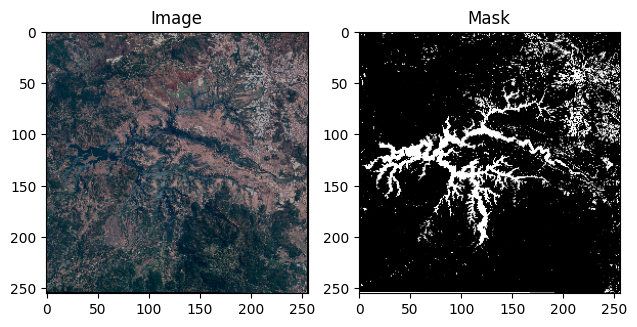

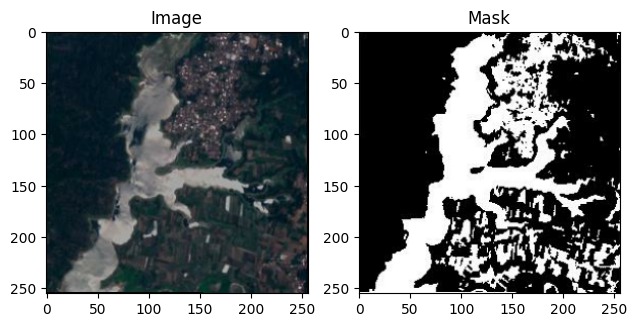

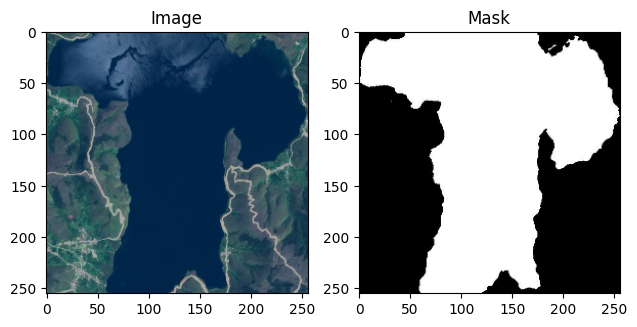

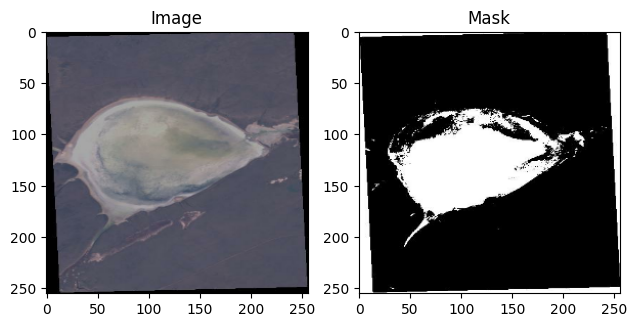

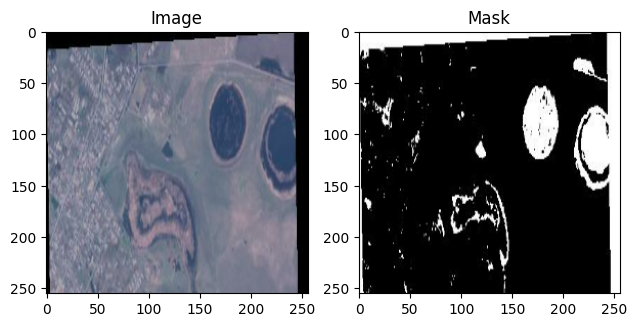

In [ ]:
for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(images[i])
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[i])
    plt.title('Mask')

    plt.tight_layout()
    plt.show()

## Data Preprocessing and Preparation


In [ ]:
X = np.zeros(shape = images.shape[:-1] + (1, ))
y = np.zeros(shape = masks.shape[:-1] + (1, ))

for i in range(X.shape[0]):
    X[i] = tf.image.rgb_to_grayscale(images[i])
    y[i] = tf.image.rgb_to_grayscale(masks[i])

print(X.shape, y.shape)

(2841, 256, 256, 1) (2841, 256, 256, 1)


In [ ]:
X = X / 255.0
y = y / 255.0

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.1, random_state = 3)

print(X_train.shape, X_test.shape)

(2556, 256, 256, 1) (285, 256, 256, 1)


## Importing Segment Anything Model (SAM)

In [ ]:
def get_bounding_box(ground_truth_map):
  if len(ground_truth_map.shape) == 3:
    ground_truth_map = ground_truth_map[:, :, 0]
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
class SAMDataset():
    def __init__(self, images, masks, processor=None):
        self.images = images
        self.masks = masks
        self.processor = processor
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = self.images[idx]
        ground_truth_mask = self.masks[idx]
        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        inputs["ground_truth_mask"] = ground_truth_mask
        return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
train_dataset = SAMDataset(images=images, masks=masks, processor=processor)


In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256, 3)


In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256, 3])


load the model

In [ ]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

## Model Architecture

In [ ]:
!pip install -qU monai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.5 MB/s eta 0:00:00


In [ ]:
import monai
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric, MeanIoU


from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

## Fine Tune loss and function metrics

In [ ]:
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')


## Training

In [ ]:
#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


  0%|          | 0/1421 [00:00<?, ?it/s]